**Маркетинговая аналитика в Яндекс.Афише**

Задание: помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.

Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Необходимо изучить:
- как клиенты пользуются сервисом,
- когда делают первые покупки на сайте,
- сколько денег приносит компании каждый клиент,
- когда расходы на привлечение клиента окупаются.



## Подготовка данных

In [1]:
#импортируем библиотеки
import pandas as pd

from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

import warnings
warnings.simplefilter('ignore')

In [2]:
#извлекаем данные

visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [3]:
#осуществим первичный взгляд

print('Метод head и info для таблиц')

display(visits.head())
visits.info()

display(orders.head())
orders.info()

display(costs.head())
costs.info()


Метод head и info для таблиц


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [4]:
#убрать пробелы и в нижний регистр
visits.set_axis(['device','end_ts','source_id','start_ts','uid'],axis='columns',inplace=True)
orders.set_axis(['buy_ts','revenue','uid'],axis='columns',inplace=True)

visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%Y-%m-%d %H:%M:%S')
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%Y-%m-%d %H:%M:%S')
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format='%Y-%m-%d %H:%M:%S')
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')


In [5]:
#проверим столбцы с выручкой и затратами на нули
display(orders['revenue'].describe())
display(len(orders[orders['revenue'] == 0]))
display(costs['costs'].describe())

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

51

count    2542.000000
mean      129.477427
std       156.296628
min         0.540000
25%        21.945000
50%        77.295000
75%       170.065000
max      1788.280000
Name: costs, dtype: float64

Обнаружили нули в столбце Сумма заказа, 51 строчка больше похожа на артефакт, либо это какие-то промо-заказы или по подарочным сертификатам, например. Их количество незначительно, поэтому можно оставить, но спросить у разработчиков, откуда они, будет не лишним.

In [6]:
#проверим равенство диапазонов дат
display(costs['dt'].describe())
display(orders['buy_ts'].describe())
display(visits['start_ts'].describe())
display(visits['end_ts'].describe())

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

count                  359400
unique                 224303
top       2017-11-24 16:06:00
freq                       19
first     2017-06-01 00:01:00
last      2018-05-31 23:59:00
Name: start_ts, dtype: object

count                  359400
unique                 224760
top       2017-11-24 16:51:00
freq                       23
first     2017-06-01 00:02:00
last      2018-06-01 01:26:00
Name: end_ts, dtype: object

В таблицу с заказами и визитами пробрались строчки из июня 2018, хотя по условиям у нас должно быть конец мая. Исправим это, чтобы временные рамки везде совпадали.

In [7]:
orders = orders.query('buy_ts < "2018-06-01"')
visits = visits.query('end_ts < "2018-06-01"')

In [8]:
print('Значения типов устройств: ', visits['device'].unique())
print('Значения источников: ', visits['source_id'].unique())


Значения типов устройств:  ['touch' 'desktop']
Значения источников:  [ 4  2  5  9  3  1 10  7  6]


Типов устройст только 2: мобильное устройство и десктоп. А значения источников зашифрованы в цифрах, вероятно для сохранения коммерческой тайны.

## Расчет метрик

### Продуктовые метрики

Рассчитаем DAU, WAU и MAU. Вычислим средние значения этих метрик за весь период и отобразим изменения метрик во времени на графиках.

In [11]:
visits['session_year']  = visits['start_ts'].dt.year
visits['session_month']  = visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.week
visits['session_date']  = visits['start_ts'].dt.date
display(visits.head())

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


In [12]:
#сначала расчет за весь период
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()
wau_total = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean()
mau_total = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean()

print('Среднее количество уникальных пользователей в день за все время: ', int(dau_total))
print('Среднее количество уникальных пользователей в неделю за все время: ', int(wau_total))
print('Среднее количество уникальных пользователей в месяц за все время: ', int(mau_total))

Среднее количество уникальных пользователей в день за все время:  907
Среднее количество уникальных пользователей в неделю за все время:  5716
Среднее количество уникальных пользователей в месяц за все время:  23227


Статистика в целом неплохая, почти тысяча разных людей в день заходят на сервис, а за месяц приходит небольшой поселок. В принипе показатели неплохие и есть с чем работать. Посмотрим их в динамике.

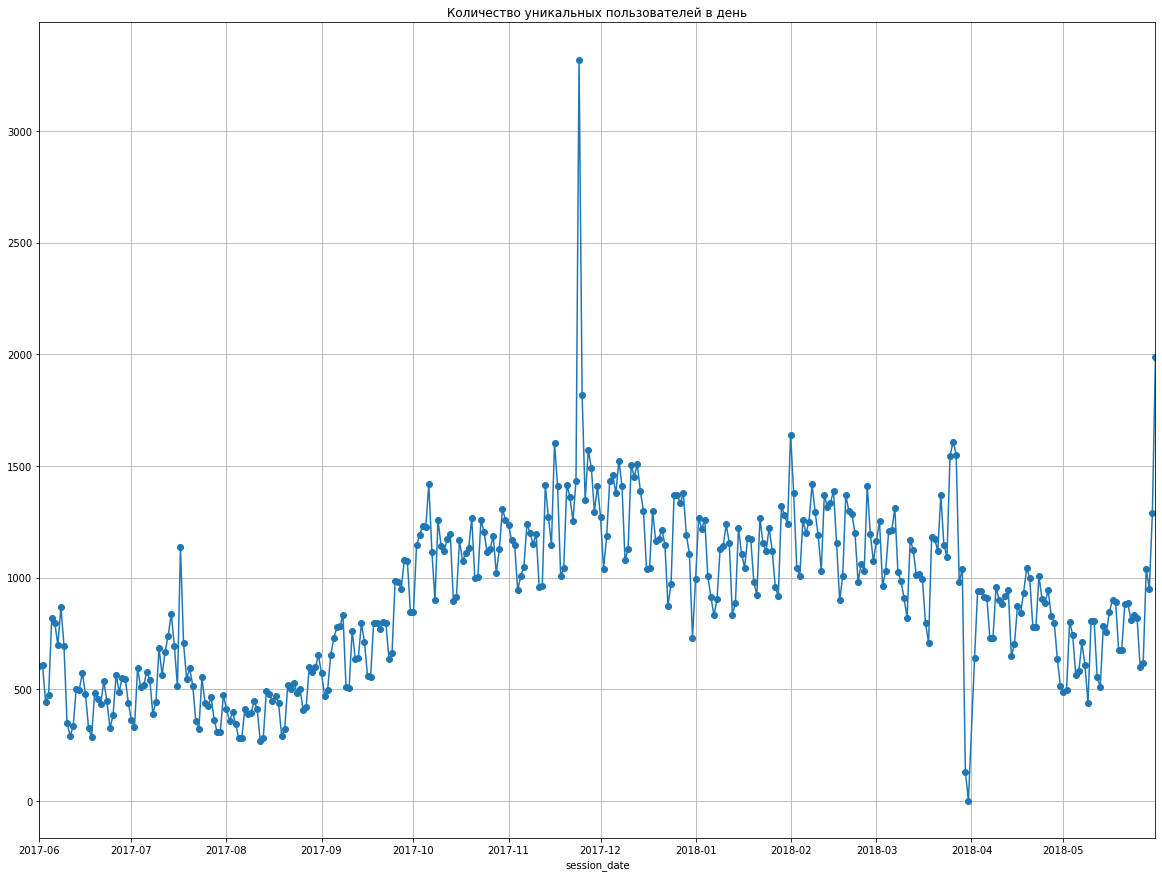

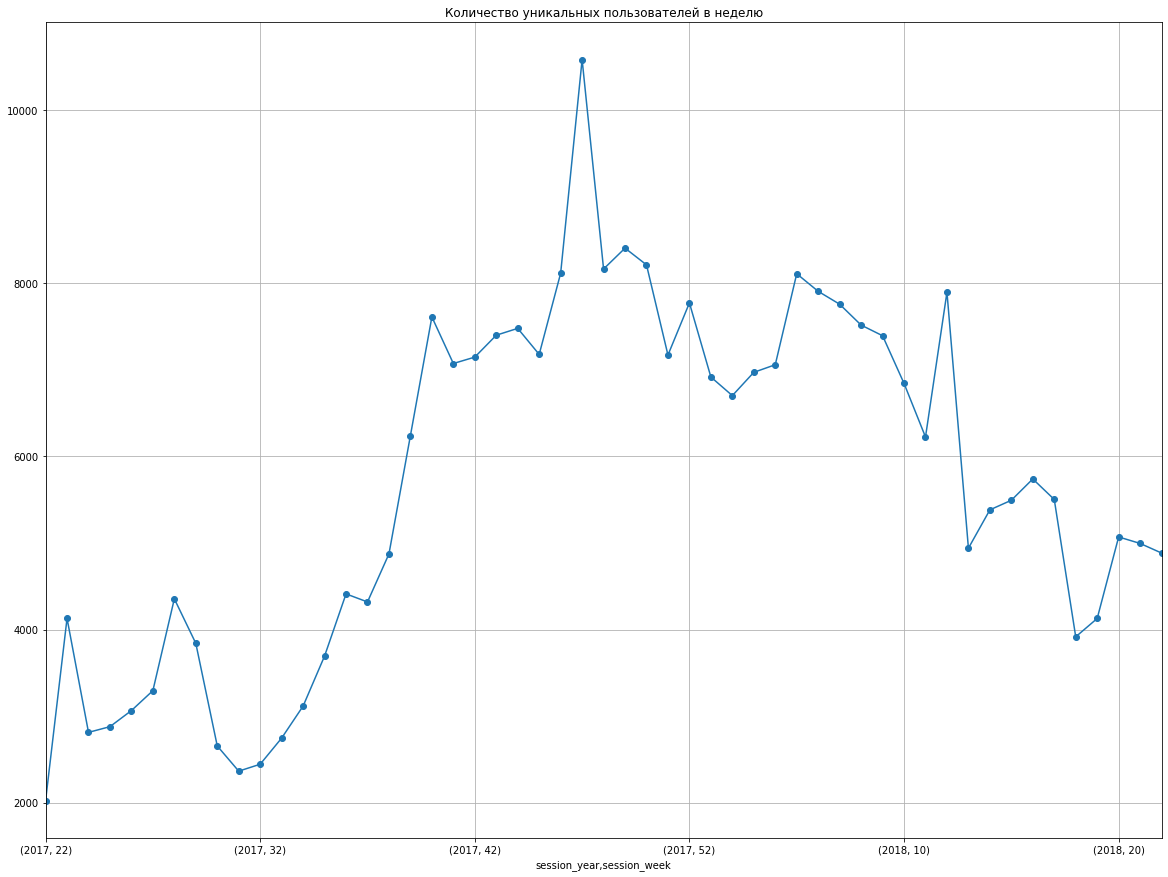

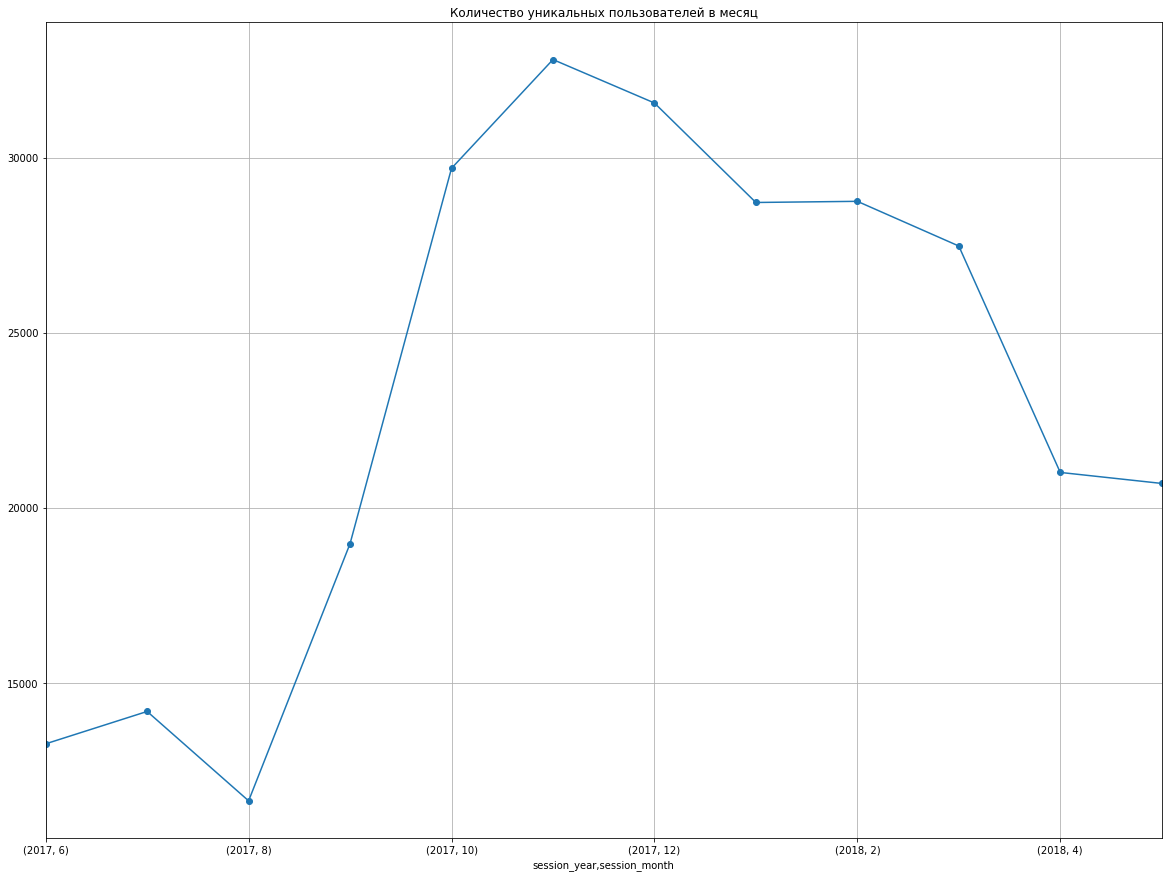

In [13]:
dau = visits.groupby('session_date').agg({'uid': 'nunique'})
wau = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'})
mau = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'})

dau.plot(y='uid', style='o-', figsize=(20, 15), grid=True, title='Количество уникальных пользователей в день', legend=False)
plt.show()
wau.plot(y='uid', style='o-', figsize=(20, 15), grid=True, title='Количество уникальных пользователей в неделю', legend=False)
plt.show()
mau.plot(y='uid', style='o-', figsize=(20, 15), grid=True, title='Количество уникальных пользователей в месяц', legend=False)
plt.show()

По графикам в динамике наблюдается сезонность: осенью активизируется активность, пик приходился на ноябрь-декабрь, и к маю активность постепенно снижалась.

Определим, сколько раз за день пользователи в среднем заходят на сайт. Построим график, отражающий изменения метрики во времени

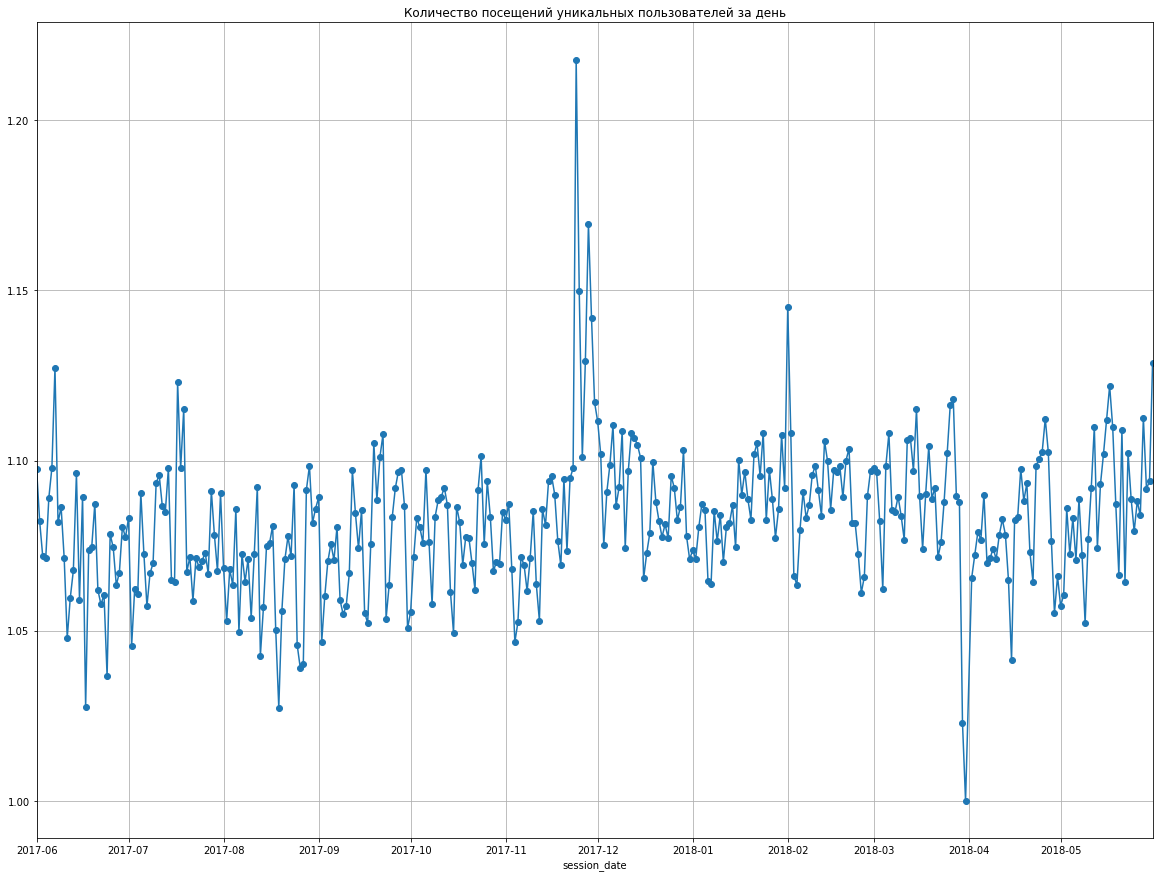

Среднее количество посещений уникальных пользователей за день:  1.0821671112951867


In [14]:
dau_daily = visits.groupby('session_date').agg({'uid': 'nunique', 'start_ts':'count'})
dau_daily['mean'] = dau_daily['start_ts'] / dau_daily['uid']
dau_daily.columns = ['uid','sessions','mean']

dau_daily.plot(y='mean', style='o-', figsize=(20, 15), grid=True, title='Количество посещений уникальных пользователей за день', legend=False)
plt.show()
print('Среднее количество посещений уникальных пользователей за день: ', dau_daily['mean'].mean())

Среднее число заходов одного человека за день не превышает 1,3 даже в пиковые дни. Это вероятно означает одну из двух крайностей: пользователь заходит на сайт и с первого раза решает там свою задачу либо наоборот не решает, выходит и больше не пробует. 

Теперь исследуем, сколько времени пользователи проводят на сайте. Узнаем продолжительность типичной пользовательской сессии за весь период. Построим график распределения, чтобы выбрать подходящую среднюю меру. Изменение продолжительности сессий во времени изучать необязательно.

In [15]:
#сначала посчитаем среднее
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
display(visits['session_duration_sec'].mean()) 
visits['session_duration_sec'].describe()

643.4657028058812

count    359388.000000
mean        643.465703
std        1016.280993
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

In [16]:
#попробуем измерить продолжительность методом total_seconds
visits['session_duration_sec_ts'] = (visits['end_ts'] - visits['start_ts']).dt.total_seconds()
display(visits['session_duration_sec_ts'].mean()) 
visits['session_duration_sec_ts'].describe()

642.9848854163189

count    359388.000000
mean        642.984885
std         997.072264
min       -2760.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       42660.000000
Name: session_duration_sec_ts, dtype: float64

Среднее получилось 643 секунды, то есть около 10 минут. Если подумать, то это многовато для того, чтобы зайти на сайт и купить билет на концерт. Посмотрим распределение.

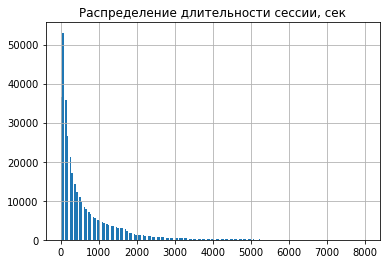

In [17]:
plt.title('Распределение длительности сессии, сек')
visits['session_duration_sec'].hist(bins=200, range=(0,8000)) 

Распределение явно не нормальное, значит попробуем посчитать моду, самое часто встречающееся в выборке.

In [18]:
display(visits['session_duration_sec'].mode()) 

0    60
dtype: int64

Мода получилась 60 секунд. Николасу Кейджу этого достаточно, чтобы угнать авто, но даже он вряд ли успеет купить билет на афише за это время. Посмотрим медиану тогда.

In [19]:
display(visits['session_duration_sec'].median()) 

300.0

300 секунд или 5 минут, это не много и не мало в нашем случае, поэтому медиана является показателем самой типичной продолжительности на сайте. А самое частое время в 1 минуту надо взять на заметку, вероятно, многим пользователям что-то не понравилось на сайте и они быстро заканчивали с ним работать.

Далее рассчитаем Retention Rate, применяя когортный анализ. Покажем изменения метрики во времени на графике и найдем средний Retention Rate на второй месяц «жизни» когорт.

In [20]:
# возьмём дату, когда пользователь впервые проявил активность на сайте
# и данные запишем в объект Series first_session_date. Объединим его с исходным датафреймом visits
first_session_date = visits.groupby(['uid'])['session_date'].min()
first_session_date.name = 'first_session_date'
visits = visits.join(first_session_date,on='uid')
display(visits.head())

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec,session_duration_sec_ts,first_session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080,1080.0,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680,1680.0,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0,0.0,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440,1440.0,2018-03-09
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0,0.0,2017-12-27


In [21]:
# Следующим шагом выделим из столбцов first_session_date и session_date месяцы
visits['first_session_month'] = visits['first_session_date'].astype('datetime64[M]')
visits['session_month'] = visits['session_date'].astype('datetime64[M]')
display(visits.head()) 

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec,session_duration_sec_ts,first_session_date,first_session_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12-01,51,2017-12-20,1080,1080.0,2017-12-20,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02-01,8,2018-02-19,1680,1680.0,2018-02-19,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,2017-07-01,26,2017-07-01,0,0.0,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-01,20,2018-05-20,1440,1440.0,2018-03-09,2018-03-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,2017-12-01,52,2017-12-27,0,0.0,2017-12-27,2017-12-01


In [22]:
#рассчитаем lifetime пользователя в рамках когорты
visits['cohort_lifetime'] = visits['session_month'] - visits['first_session_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')
display(visits.head()) 

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec,session_duration_sec_ts,first_session_date,first_session_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12-01,51,2017-12-20,1080,1080.0,2017-12-20,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02-01,8,2018-02-19,1680,1680.0,2018-02-19,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,2017-07-01,26,2017-07-01,0,0.0,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-01,20,2018-05-20,1440,1440.0,2018-03-09,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,2017-12-01,52,2017-12-27,0,0.0,2017-12-27,2017-12-01,0


Средний Retention Rate на второй месяц «жизни» когорт: 4.63%


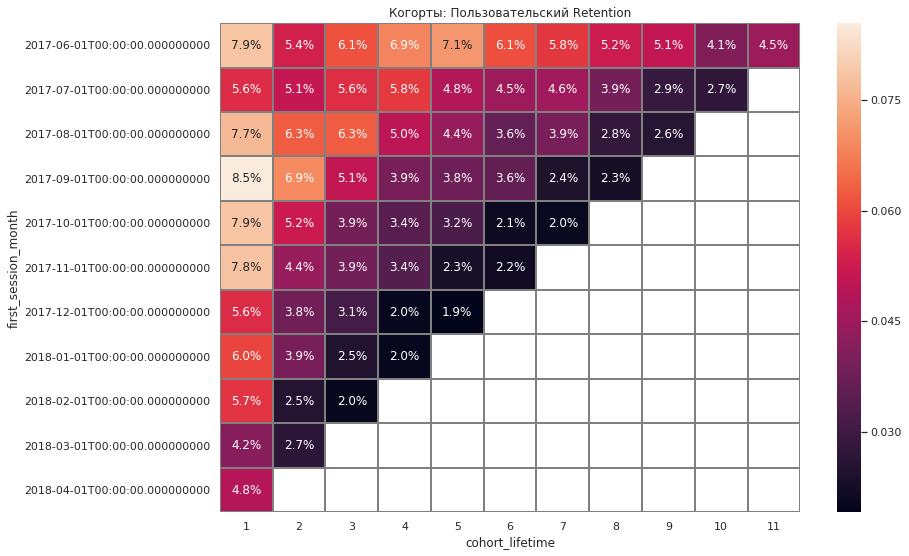

In [23]:
# Сгруппируем данные по когорте и lifetime
cohorts = visits.groupby(['first_session_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

#получим число пользователей, изначально бывших в когорте 
#и на него разделим число пользователей в каждый следующий месяц
#это будет retention rate

#найдём исходное количество пользователей в когорте. Возьмём их число на нулевой месяц
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_session_month', 'uid']]

#переименуем столбец uid в cohort_users
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

#объединим данные по когортам с исходным количеством пользователей в когорте
cohorts = cohorts.merge(initial_users_count,on='first_session_month')

#посчитаем retention rate
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

#оставим в данных о месяце первого заказа только год и месяц
#cohorts_final = cohorts
#cohorts_final['first_session_month'] = cohorts_final['first_session_month'].dt.strftime('%Y-%m')

#строим сводную и потом тепловую карту
retention_pivot = cohorts.query('cohort_lifetime > 0').pivot_table(
    index='first_session_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum')



sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Когорты: Пользовательский Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

# плюс посчитаем средний retention на 2м месяце жизни
print('Средний Retention Rate на второй месяц «жизни» когорт: {:.2%}'.format(cohorts.query('cohort_lifetime == 2')['retention'].mean()))

На первый взгляд расчетный RR ужасен, однако если вникнуть в отрасль, то это можно хоть как-то объяснить. Покупка билетов на мероприятие на самом деле не такая уж и частая вещь в жизни людей, мало кто ходит куда-то даже каждый месяц, не то что неделю, спрос на билеты не такой постоянный, как на хлеб в супермаркете. Условно один поход в театр/на концерт может удовлетворить человека на несколько месяцев вперед, да и сами артисты/группы гастролируют бывает не чаще 1-2 раза в год. Поэтому пользователи однажды посмотрев билеты могут вернуться еще не скоро (средний retention на 2 месяц 4,63%), и причиной скорее всего не будет наш сайт. 

Но даже в таких реалиях не стоит пренебрегать своим продуктом и анализировать поведение пользователей.
Практически у всех когорт наблюдается постепенное снижение показателя retention. Однако самая долгоиграющая когорта - первая, июнь 2017, на последнюю точку в lifetime у них показатель 4,5, тогда как у других когорт этот показатель практически в 2 раза меньше: 1,9-2,7. Значит, что вероятно с июля 2017 было какое-то изменение на афише, которое не так сильно возвращает пользователей со временем.
Также видно, что в феврале 2018 массовый всплеск у всех когорт, может быть было какое-то массовое событие или крупная рекламная кампания.

Добавить к этим выводам можно те факты, что у нас около тысячи посетителей в день, и, выходит, из них очень маленькая доля повторных заходов. И в среднем пользователь проводит не более одной сессии в день длиной в среднем около 5 минут. Плюс сезонный спрос с пиком на ноябрь-декабрь и классическим летним спадом.

### Метрики электронной коммерции

Исследуем, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки.

Среднее количество минут от первого посещения до первой покупки:  249.17143091835058


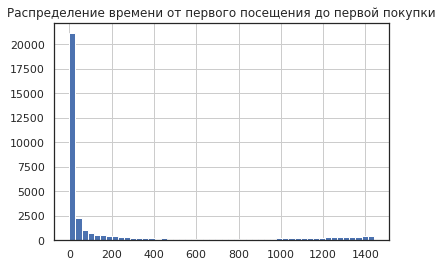

In [24]:
#соединим таблицы с первым визитом и первой покупкой
first_buy = orders.pivot_table(index='uid', values='buy_ts', aggfunc='min')

#возьмем таблицу с первым посещением из продуктовых метрик
first_session_date = visits.groupby(['uid'])['start_ts'].min()
first_session_date.name = 'first_visit'

#соединяем
first_buy = first_buy.join(first_session_date, on='uid')

#считаем разницу
first_buy['delta'] = (first_buy['buy_ts'] - first_buy['first_visit']).dt.seconds
first_buy['delta'] = first_buy['delta'] / 60 #переведем в минуты для наглядности
first_buy = first_buy.rename(columns={'delta':'delta_min'})

print('Среднее количество минут от первого посещения до первой покупки: ', first_buy['delta_min'].mean())
plt.title('Распределение времени от первого посещения до первой покупки')
first_buy['delta_min'].hist(bins=50)

Среднее время до покупки получилось 4 часа. Наверное это многовато. Учитывая ненормальное распределение, стоит взглянуть на моду и медиану.

In [25]:
print('Медиана: ',first_buy['delta_min'].median()) 
print('Мода: ',first_buy['delta_min'].mode()) 

Медиана:  16.0
Мода:  0    1.0
dtype: float64


Интересно, что мода равна одной минуте, значит есть очень много операций, где пользователи пришли и купили практически не думая. Вероятно это трафик из сторонних источников, где пользователь уже подготовился к покупке (например, тематические сайты или сайты/социальные сети артистов) и воспользовался афишей только чтобы провести транзакцию. Такой трафик неплохой для сервиса, но нам же важно быть не только кладовщиком, который лишь отпускает товар. 

И снова самой реальной цифрой стала медиана - 16 минут, т.к. на среднюю очень сильно повлияли пользователи, которые не купили в моменте а пришли через несколько часов или вообще на следующий день. 16 минут - это то время, которое в среднем затрачивает пользователь на нашем сайте на покупку, если он впервые открыл афишу. Если подумать, то это отличный показатель, т.к. очень много уникальных пользователей, которые первый раз пришли, покупают там билет за столь такой небольшой промежуток. Значит, ресурс обладает хорошими характеристиками, которые ведут посетителя сразу в конверисию.

Далее рассчитаем среднее количество покупок на одного покупателя в пиковый период посещаемости: с октября по март.

In [26]:
#добавляем столбец с месяцем покупки
orders['order_month']  = orders['buy_ts'].dt.month

#выделяем пиковые месяца
peak_months=[10,11,12,1,2,3]
purchases_mean = orders.query('order_month in @peak_months').groupby(['uid']).agg({'revenue': 'count'})

print('Cреднее количество покупок на 1 покупателя с октября по март: {:.2f}'.format(purchases_mean['revenue'].mean()))

Cреднее количество покупок на 1 покупателя с октября по март: 1.35


Получили 1.35. Это больше чем 1, уже неплохо - пользователи возвращаются, но можно и лучше.

Следующим шагом рассчитаем средний чек, применяя группировку по времени совершения покупки, и построим график, отражающий изменения метрики во времени. Возьмем шаг во времени неделю, чтобы данные были более детализированными.

In [27]:
#добавляем столбец с неделей покупки
orders['order_week']  = orders['buy_ts'].astype('datetime64[W]')

orders.head()

,buy_ts,revenue,uid,order_month,order_week
0,2017-06-01 00:10:00,17.00,10329302124590727494,6,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,6,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,6,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,6,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,6,2017-06-01


In [28]:
#считаем количество и общую сумму заказов в каждой неделе
mean_check = orders.groupby('order_week').agg({'revenue': ['count', 'sum']})
mean_check.columns=['count','sum']

#получаем средний чек
mean_check['mean'] = mean_check['sum'] / mean_check['count']
mean_check.head()

,count,sum,mean
order_week,,,
2017-06-01,896,2546.66,2.842254
2017-06-08,525,2536.51,4.831448
2017-06-15,341,1527.33,4.478974
2017-06-22,441,2099.22,4.760136
2017-06-29,461,2449.82,5.314143


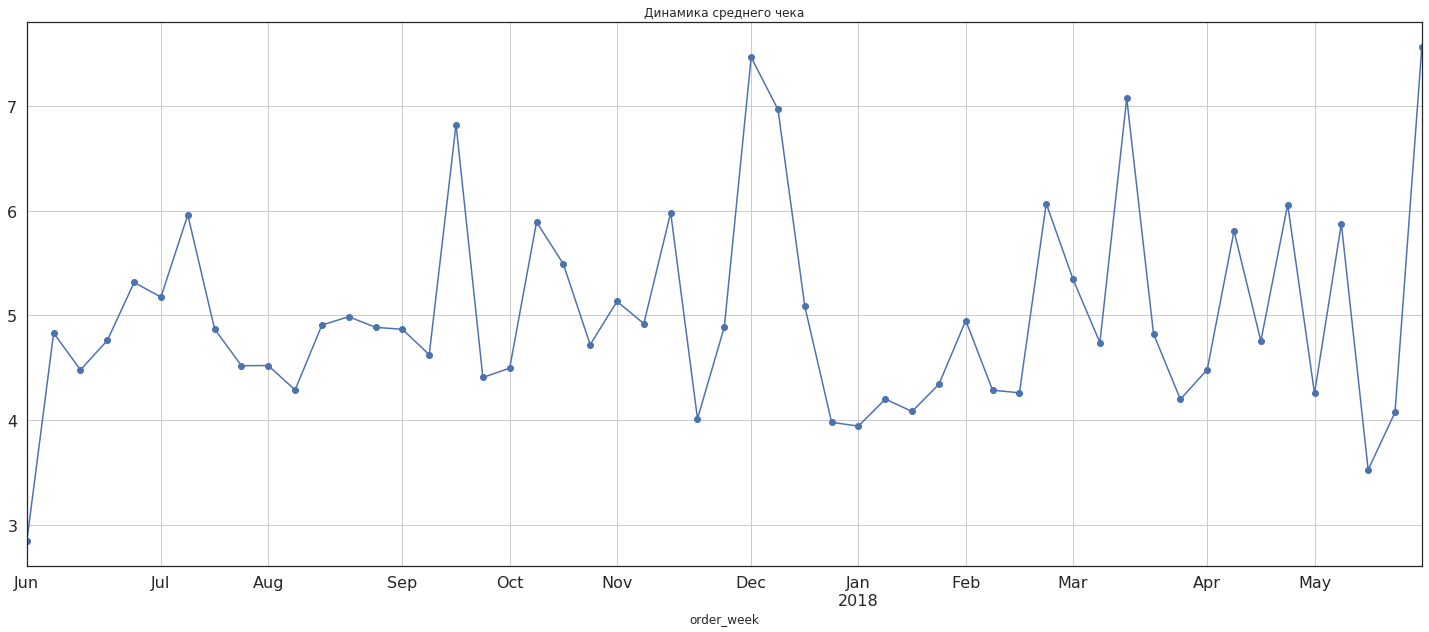

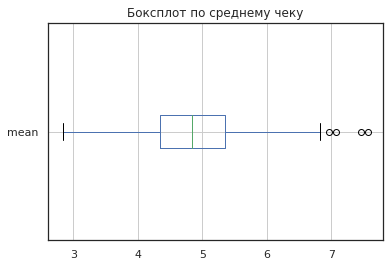

In [29]:
#и построим график
mean_check.plot(y='mean', style='o-', grid=True, figsize=(25, 10), title='Динамика среднего чека', legend=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

#плюс боксплот, чтобы оценить рассеяние значений
plt.title('Боксплот по среднему чеку')
mean_check.boxplot(column='mean', vert = False)
plt.show()

Динамика среднего чека похожа на американские горки, не наблюдается какой-то стабильности или плавных подъемов/спадов. Эту непредсказуемость конечно сложно как-то учитывать: сегодня у тебя чек один, а завтра он может взлететь в 1,5 раза, и наоборот. Поэтому разброс среднего чека примерно от 3 до 7 тысяч рублей, и выбросы в болшую сторону на боксплоте не кажутся такими уж и выбросами. Вероятно, все-таки разношерстные исполнители влияют на это: можно купить билет на Beyonce и улететь в космос, либо пойти в музей за 500 рублей. Отсюда некоторые недели в году резко подлетают по среднему чеку, видимо поступают в продажу билеты на концерты топовых исполнителей.

Ну и из очевидного можно отметить, что в начале декабря средний чек практически самый высокий в году, а в январе он резко падает.

Далее выясним, как меняется LTV на покупателя по когортам. Рассчитаем средний LTV по когортам за 6 месяцев; в расчёт включим когорты, «прожившие» не менее 6 месяцев. Отразим изменения метрики во времени на графике.

In [30]:
#выделим в таблице первые месяцы когорт
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

orders.head()

,buy_ts,revenue,uid,order_month,order_week
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01


In [31]:
#получим месяц первой покупки каждого покупателя
first_order = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_order.columns = ['uid','first_order_month']
first_order.head()

,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


In [32]:
#посчитаем количество новых покупателей n_buyers за каждый месяц
cohort_sizes = first_order.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'new_buyers']
display(cohort_sizes.head()) 

,first_order_month,new_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [33]:
#построим когорты. Добавим месяц первой покупки каждого покупателя в таблицу с заказами
orders_new = pd.merge(orders,first_order, on='uid')
display(orders_new.head()) 

,buy_ts,revenue,uid,order_month,order_week,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01


In [34]:
#сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку
cohorts = orders_new.groupby(['first_order_month','order_month']).agg({'revenue':'sum'}).reset_index()
display(cohorts.head())

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [35]:
#добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
display(report.head())

,first_order_month,new_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


In [36]:
#так как маржинальность сервиса 100%, то параметр margin rate не задаем, он равен 1
#и gross profit будет равна revenue
#добавим возраст когорты в таблицу

report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

#найдём LTV: разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте
report['ltv'] = report['revenue'] / report['new_buyers']

#выведем таблицу для наглядности
output = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean')
output.cumsum(axis=1).round(2).fillna('')


age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.5,7.66,7.78,7.92,8.08,8.23,8.39,
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.38,7.59,7.99,8.28,8.47,,
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.4,,,,,
2017-12-01,4.74,5,5.92,6.99,7.3,7.64,,,,,,
2018-01-01,4.14,4.43,4.73,4.88,4.94,,,,,,,
2018-02-01,4.16,4.44,4.51,4.59,,,,,,,,


age,0,1,2,3,4,5,6
first_order_month,,,,,,,
2017-06-01,4.72,0.49,0.44,0.95,1.02,0.74,0.95
2017-07-01,6.01,0.34,0.62,0.36,0.18,0.16,0.12
2017-08-01,5.28,0.47,0.46,0.39,0.49,0.28,0.21
2017-09-01,5.64,1.12,0.52,3.98,0.40,0.65,0.70
2017-10-01,5.00,0.54,0.19,0.16,0.15,0.12,0.08
2017-11-01,5.15,0.40,0.20,0.32,0.15,0.05,0.11


ltv    8.387686
dtype: float64

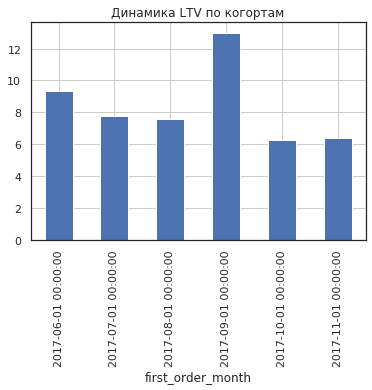

In [37]:
#посчитаем среднее LTV по когортам за 6 месяцев, ограничив расчет по когортам, прожившим не менее 6 месяцев
#выведем выборку для расчета
display(report.query('first_order_month<="2017-11-01" and age <=6').pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean').round(2))

#считаем среднее
display(report.query('first_order_month<="2017-11-01" and age <=6').groupby('first_order_month').agg({'ltv':'sum'}).mean())

#выводим на график динамику во времени
report.query('first_order_month<="2017-11-01" and age <=6').groupby('first_order_month').agg({'ltv':'sum'}).plot(y='ltv', kind='bar', grid=True, legend=False, title='Динамика LTV по когортам')

Средний LTV за 6 месяцев составил 8.39 тысяч рублей, а на графике видно, что когорта сентябрьских покупателей имеет самую большую накопленную ценность из всех остальных (около 13 тысяч). Вероятно, тогда была проведена успешная рекламная компания. А получившееся среднее LTV за 6 месяцев поможет рассчитать оптимальные затраты на привлечение клиентов.

Также следует учитывать, что в среднем пользователь тратит 16 минут с первого захода до первой покупки, что является отличным результатом. Еще на сервисе много покупателей с этим временем в 1 минуту, вероятно они приходят из других ресурсов и используют афишу только для покупки билетов.

Среднее количество покупок на одного пользователя - 1,35 в месяц даже в пиковый период, что подтверждает предположение о том, что человек обычно не склонен часто посещать культурные мероприятия.
Динамика среднего чека мало что может сказать, она практически непредсказуема, несчитая подъема в начале декабря и спада в январе.

### Маркетинговые метрики

Посчитаем общую сумму расходов на маркетинг. Выясним, как траты распределены по источникам, и визуализируйте изменения метрик во времени

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


Общая сумма расходов на маркетинг:  329131.62


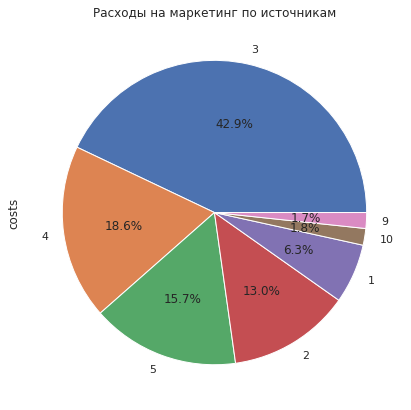

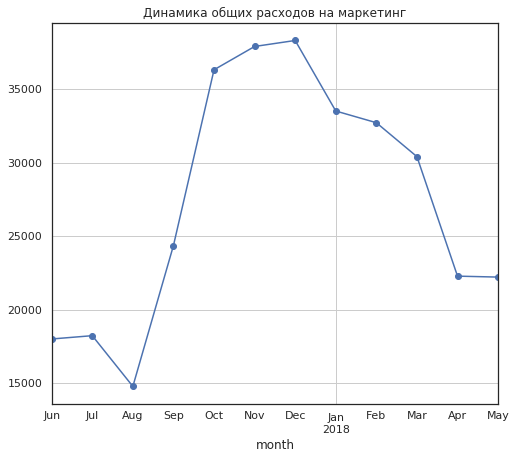

In [38]:
costs['month'] = costs['dt'].astype('datetime64[M]') 
display(costs.groupby(['source_id']).agg({'costs':'sum'}))
print('Общая сумма расходов на маркетинг: ', costs['costs'].sum())

#визуализируем
costs.pivot_table(index='source_id', 
                         values='costs', 
                         aggfunc='sum').sort_values(by='costs', ascending=False).plot(y='costs', 
                                                                                  kind='pie',
                                                                                  figsize=(8,7), 
                                                                                  title='Расходы на маркетинг по источникам',
                                                                                 legend=False, 
                                                                                 autopct='%1.1f%%')
plt.show()

#визуализируем общие траты в динамике
costs.pivot_table(index='month', 
                         values='costs', 
                         aggfunc='sum').plot(y='costs',style='o-',figsize=(8,7),title='Динамика общих расходов на маркетинг',grid=True,legend=False)
plt.show()

Динамика расходов по каждому источнику трафика


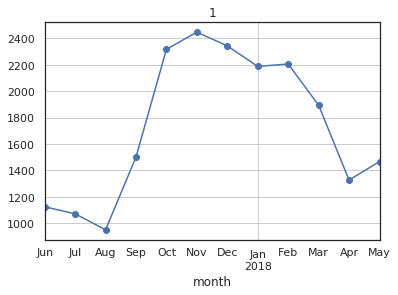

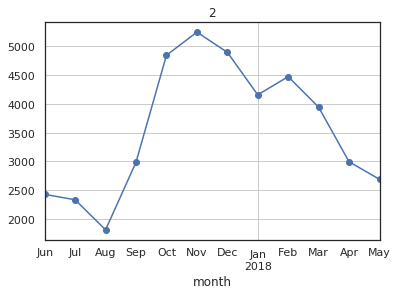

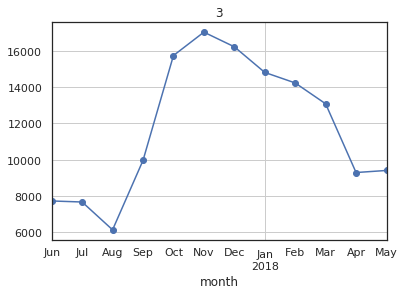

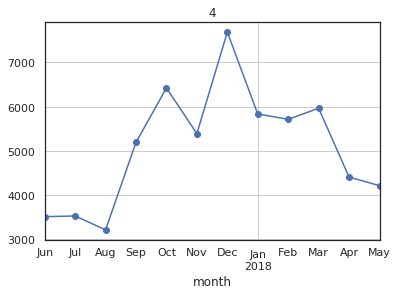

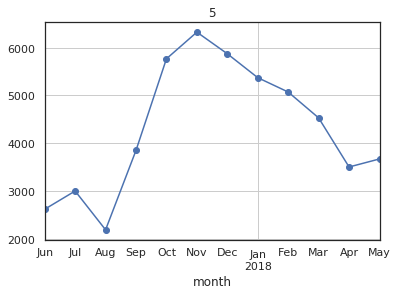

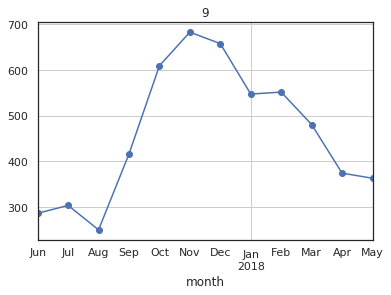

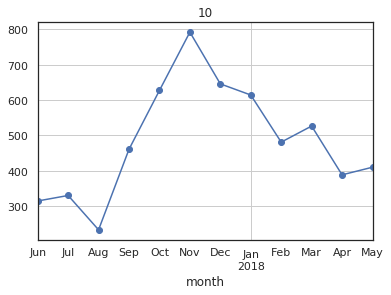

In [39]:
print('Динамика расходов по каждому источнику трафика')
sources = [1,2,3,4,5,9,10]
sources_gr = costs.groupby(['source_id', 'month']).agg({'costs':'sum'}).reset_index()

for row in sources:
    sources_gr.query('source_id == @row').plot(x='month', y='costs', grid=True, style='o-',title=row, legend=False)
    plt.show()

Почти половину в бюджете занял источник 3, потом 18% и 15% занимают источники 4 и 5 соответственно, в сумме эти три направления составят 3/4 от всего бюджета. Интересно будет посмотреть, насколько эффективны эти каналы. 

По динамике наблюдается общая у всех источников картина: выход на пик в октябрь-декабрь, потом спад до мая. Очевидно, что маркетологи не распределяли бюджет по источникам, а использовали его равномерно во всех периодах.

Далее рассчитаем средний CAC для всего проекта. Отразим изменение метрики на графике.

Средний САС для всего проекта:  cac    9.147357
dtype: float64


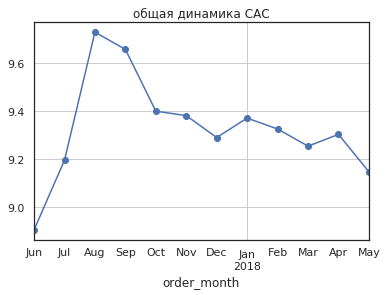

In [40]:
# считаем расходы за месяц
monthly_costs = costs.pivot_table(index='month',values='costs',aggfunc='sum')

#добавим информацию по расходам
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_new['cac'] = report_new['costs'] / report_new['new_buyers']
print('Средний САС для всего проекта: ', report_new.groupby('first_order_month').agg({'cac':'mean'}).mean())

report_new.groupby('order_month').agg({'cac':'mean'}).plot(y='cac',grid=True, style='o-',title='общая динамика CAC', legend=False) 
plt.show()

Теперь рассчитаем САС и ROMI по когортам в разрезе источников. Сравним окупаемость за одинаковые периоды жизни когорт. Построим графики, отражающие изменения метрик во времени.

Для этого заново проведем расчет LTV c учетом источников, потом добавив туда данные по расходам.

In [41]:
# узнаем источник трафика для каждого юзера по каждой сессии
first_source = visits.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'source_id': 'first', 'session_month': 'first'})

report_newnew = orders.merge(first_source, left_on='uid', right_on='uid')

report_newnew.head()

,buy_ts,revenue,uid,order_month,order_week,source_id,session_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,1,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,3,2017-06-01


In [42]:
#возьмем таблицу с выручкой и источниками
#и получим месяц первой покупки каждого покупателя
first_order = report_newnew.groupby(['uid','source_id']).agg({'order_month': 'min'}).reset_index()
first_order.columns = ['uid','source_id','first_order_month']
first_order.head()

,uid,source_id,first_order_month
0,313578113262317,2,2018-01-01
1,1575281904278712,10,2017-06-01
2,2429014661409475,3,2017-10-01
3,2464366381792757,5,2018-01-01
4,2551852515556206,5,2017-11-01


In [43]:
#посчитаем количество новых покупателей n_buyers за каждый месяц
cohort_sizes = first_order.groupby(['first_order_month','source_id']).agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month','source_id', 'new_buyers']
display(cohort_sizes.head()) 

,first_order_month,source_id,new_buyers
0,2017-06-01,1,190
1,2017-06-01,2,235
2,2017-06-01,3,638
3,2017-06-01,4,413
4,2017-06-01,5,384


In [44]:
#построим когорты. Добавим месяц первой покупки каждого покупателя в таблицу с заказами
orders_new = pd.merge(orders,first_order, on='uid')
display(orders_new.head()) 

,buy_ts,revenue,uid,order_month,order_week,source_id,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,1,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,3,2017-06-01


In [45]:
#сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку
cohorts = orders_new.groupby(['first_order_month','order_month','source_id']).agg({'revenue':'sum'}).reset_index()
display(cohorts.head())

,first_order_month,order_month,source_id,revenue
0,2017-06-01,2017-06-01,1,1378.70
1,2017-06-01,2017-06-01,2,1043.68
2,2017-06-01,2017-06-01,3,2804.34
3,2017-06-01,2017-06-01,4,1959.84
4,2017-06-01,2017-06-01,5,1898.89


In [46]:
#добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц
report = pd.merge(cohort_sizes, cohorts, on=['first_order_month','source_id'])
display(report.head())

,first_order_month,source_id,new_buyers,order_month,revenue
0,2017-06-01,1,190,2017-06-01,1378.70
1,2017-06-01,1,190,2017-07-01,414.98
2,2017-06-01,1,190,2017-08-01,419.43
3,2017-06-01,1,190,2017-09-01,714.24
4,2017-06-01,1,190,2017-10-01,811.20


In [47]:
#так как маржинальность сервиса 100%, то параметр margin rate не задаем, он равен 1
#и gross profit будет равна revenue

#найдём LTV: разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте
report['ltv'] = report['revenue'] / report['new_buyers']
report.head()

,first_order_month,source_id,new_buyers,order_month,revenue,ltv
0,2017-06-01,1,190,2017-06-01,1378.70,7.256316
1,2017-06-01,1,190,2017-07-01,414.98,2.184105
2,2017-06-01,1,190,2017-08-01,419.43,2.207526
3,2017-06-01,1,190,2017-09-01,714.24,3.759158
4,2017-06-01,1,190,2017-10-01,811.20,4.269474


In [48]:
monthly_source_costs = costs.pivot_table(index=['month','source_id'],values='costs',aggfunc='sum').reset_index()

monthly_source_costs.head(10)

,month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12
5,2017-06-01,9,285.22
6,2017-06-01,10,314.22
7,2017-07-01,1,1072.88
8,2017-07-01,2,2333.11
9,2017-07-01,3,7674.37


In [49]:
#соединим две таблицы с ltv и месячными затратами

report_new = pd.merge(report, monthly_source_costs, left_on=['first_order_month','source_id'], right_on=['month','source_id'])

report_new.head()

,first_order_month,source_id,new_buyers,order_month,revenue,ltv,month,costs
0,2017-06-01,1,190,2017-06-01,1378.70,7.256316,2017-06-01,1125.61
1,2017-06-01,1,190,2017-07-01,414.98,2.184105,2017-06-01,1125.61
2,2017-06-01,1,190,2017-08-01,419.43,2.207526,2017-06-01,1125.61
3,2017-06-01,1,190,2017-09-01,714.24,3.759158,2017-06-01,1125.61
4,2017-06-01,1,190,2017-10-01,811.20,4.269474,2017-06-01,1125.61


In [50]:
#добавим возраст когорты и САС в таблицу

report_new['age'] = (report_new['order_month'] - report_new['first_order_month']) / np.timedelta64(1, 'M')
report_new['age'] = report_new['age'].round().astype('int')

report_new['cac'] = report_new['costs'] / report_new['new_buyers']

report_new.head()

,first_order_month,source_id,new_buyers,order_month,revenue,ltv,month,costs,age,cac
0,2017-06-01,1,190,2017-06-01,1378.70,7.256316,2017-06-01,1125.61,0,5.924263
1,2017-06-01,1,190,2017-07-01,414.98,2.184105,2017-06-01,1125.61,1,5.924263
2,2017-06-01,1,190,2017-08-01,419.43,2.207526,2017-06-01,1125.61,2,5.924263
3,2017-06-01,1,190,2017-09-01,714.24,3.759158,2017-06-01,1125.61,3,5.924263
4,2017-06-01,1,190,2017-10-01,811.20,4.269474,2017-06-01,1125.61,4,5.924263


Динамика CAC по источникам


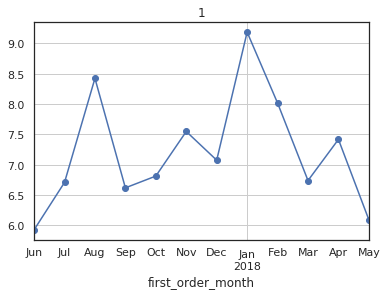

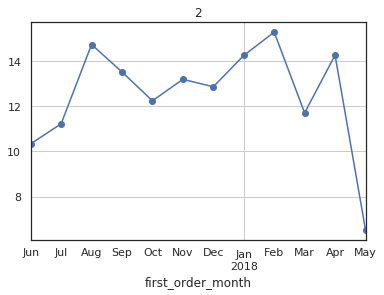

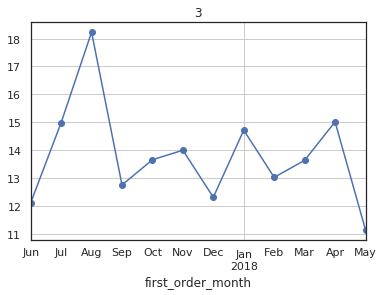

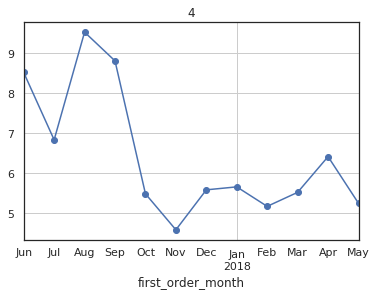

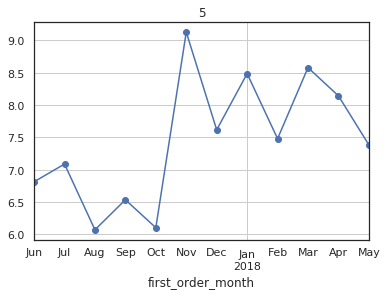

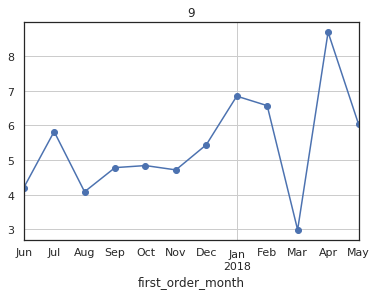

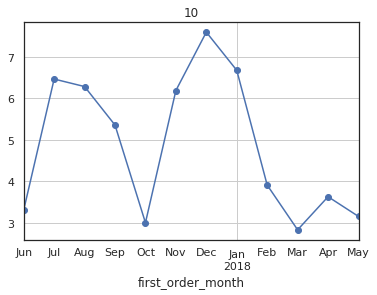

In [51]:
print('Динамика CAC по источникам')

sources = report_new['source_id'].unique()

for row in sources:
    report_new.query('source_id == @row').pivot_table(index='first_order_month',
                                                      values='cac',
                                                      aggfunc='mean').plot(y='cac',grid=True, style='o-',title=row, legend=False)
    plt.show()

In [52]:
#вычислим ROMI
report_new['romi'] = report_new['ltv'] / report_new['cac']
report_new.head()

,first_order_month,source_id,new_buyers,order_month,revenue,ltv,month,costs,age,cac,romi
0,2017-06-01,1,190,2017-06-01,1378.70,7.256316,2017-06-01,1125.61,0,5.924263,1.224847
1,2017-06-01,1,190,2017-07-01,414.98,2.184105,2017-06-01,1125.61,1,5.924263,0.368671
2,2017-06-01,1,190,2017-08-01,419.43,2.207526,2017-06-01,1125.61,2,5.924263,0.372625
3,2017-06-01,1,190,2017-09-01,714.24,3.759158,2017-06-01,1125.61,3,5.924263,0.634536
4,2017-06-01,1,190,2017-10-01,811.20,4.269474,2017-06-01,1125.61,4,5.924263,0.720676


Динамика ROMI по источникам


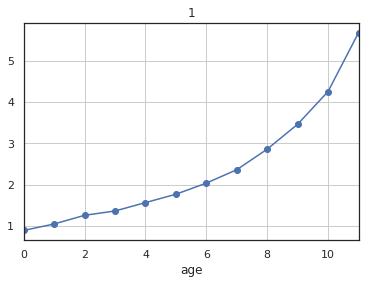

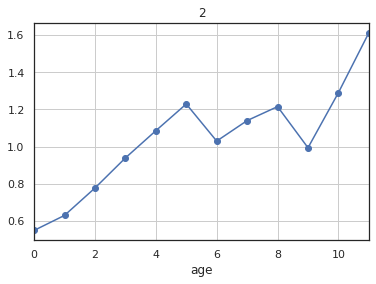

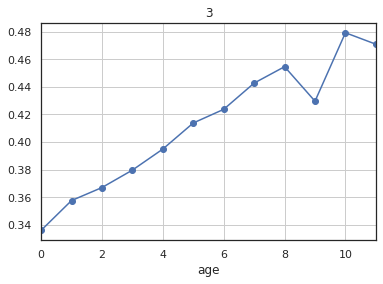

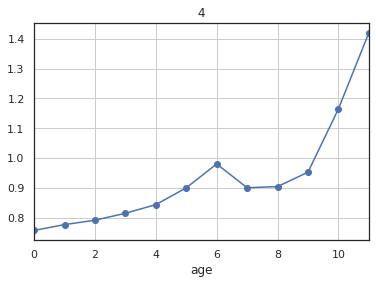

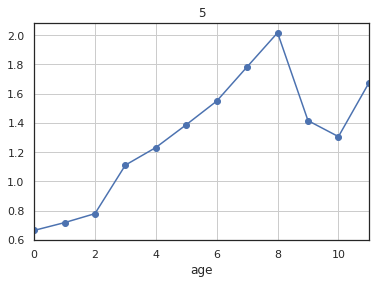

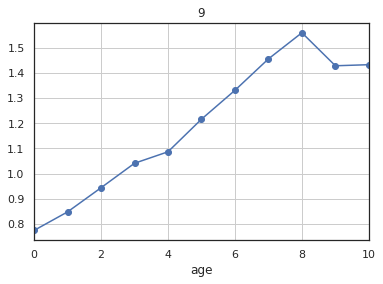

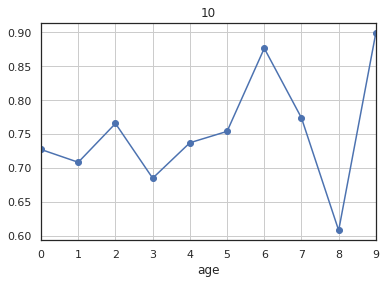

In [53]:
print('Динамика ROMI по источникам')

for row in sources:
    output = report_new.query('source_id == @row').pivot_table(index='first_order_month',
                                                            columns='age',
                                                            values='romi',
                                                            aggfunc='mean')
    output.cumsum(axis=1).mean(axis=0).plot(grid=True,title=row,style='o-',legend=False)
    plt.show()
    

Когорты: Пользовательский ROMI для каждого источника


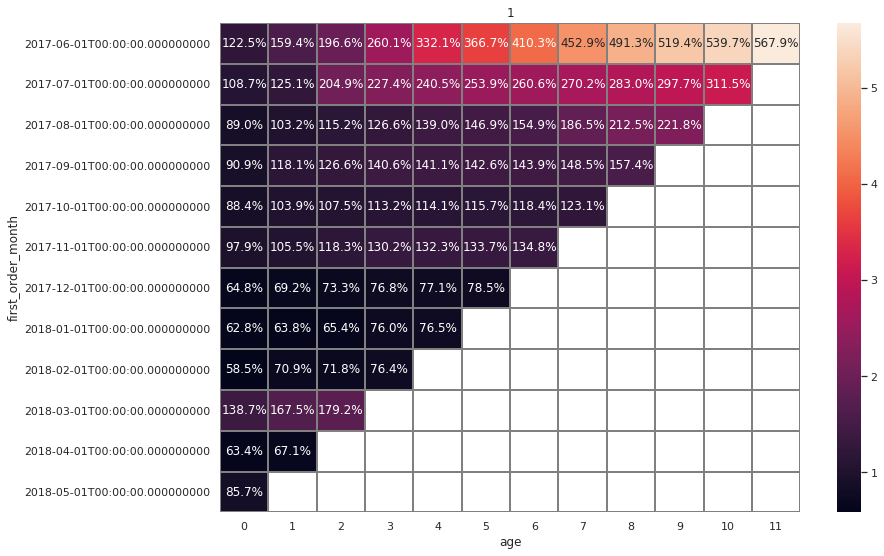

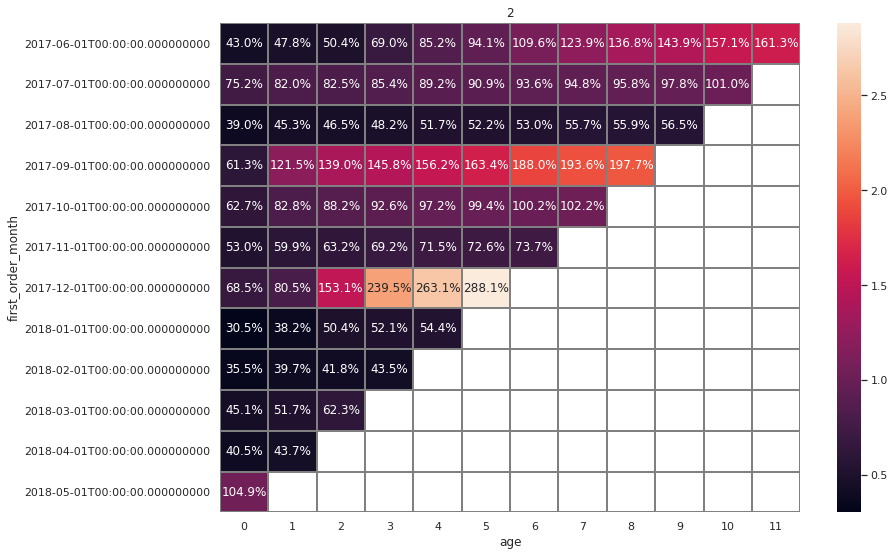

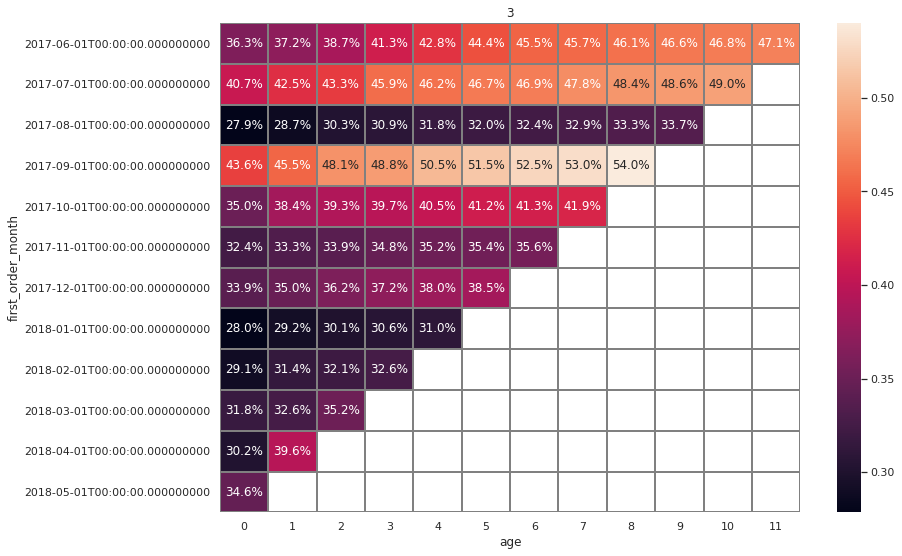

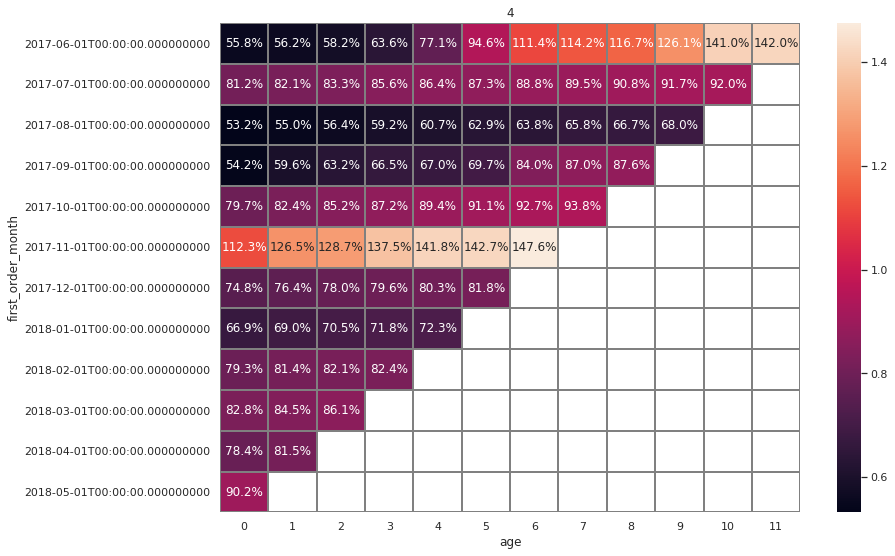

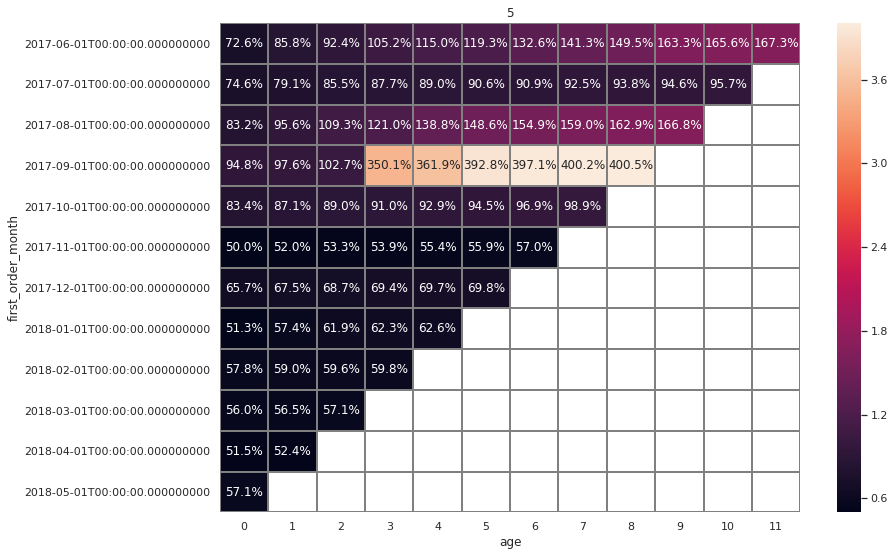

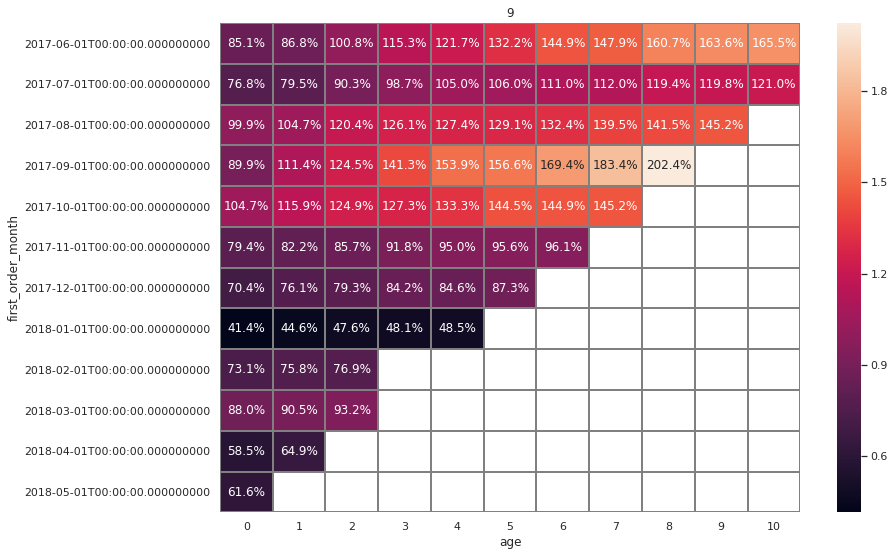

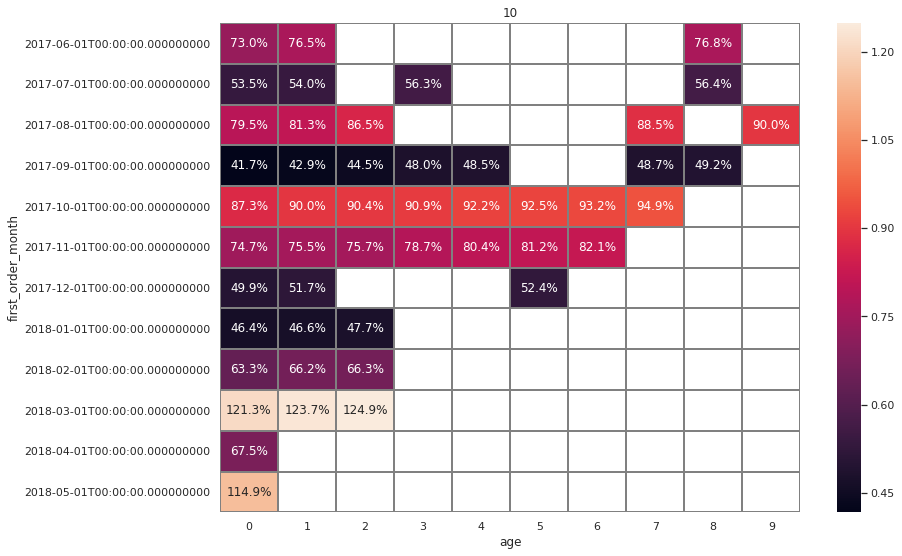

In [54]:
#строим сводную для ROMI каждого источника и потом тепловую карту
print('Когорты: Пользовательский ROMI для каждого источника')
for row in sources:
    romi_pivot = report_new.query('source_id == @row').pivot_table(
        index='first_order_month',
        columns='age',
        values='romi',
        aggfunc='mean')

    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    plt.title(row)
    sns.heatmap(romi_pivot.cumsum(axis=1), annot=True, fmt='.1%', linewidths=1, linecolor='gray');

1. Эффективность канала от когорты к когорте постепенно падает, в то время как средние значения с виду удовлетворительные, необходимо проверить данный источник на предмет причин снижения ROMI.
2. Очень нестабильны успех источника, ROMI колеблется от 40 до 300 процентов для разных когорт.
3. Абсолютно неэффективный источник, максимальный ROMI 54%
4. Разброс ROMI от 68 до 148 процентов, только две успешные когорты из всех окупились, отсюда и средняя окупаемость в 10 месяцев.
5. только 3 когорты свыше 100%  и средние значения тянет только сентябрьская когорта с romi 400%, отсюда и выдающиеся показатели в целом по источнику.
9. Начали за здравие, законичли за упокой. Стартовал источник вполне успешно, потом пошел на спад, ситуация схожа с источником №1
10. На большую часть статистики нет, значит конвертированных покупателей там не было, самый неэффективный источник.

## Выводы и рекомендации

Приоритетные источники трафика: 1, 5 и 9. Графики динамики ROMI показывают, что в среднем когорта окупается на 1-3 месяц, что добвольно быстро. Источник №2 окупается в среднем за 4 месяца, но потом не может дальше развить успех. Источник №4 окупился только на 10-й месяц. Учитывая, что он занимает почти 20% от бюджета, его необходимость можно поставить под сомнение. Источники номер 3 и 10 так и не окупили себя в течение года, поэтому их точно можно исключить из медиаплана.

На первый взгляд расчетный Retention Rate (коэффициент удержания) ужасен: от 2 до 9 процентов, однако если вникнуть в отрасль, то это можно хоть как-то объяснить. Покупка билетов на мероприятие на самом деле не такая уж и частая вещь в жизни людей, мало кто ходит куда-то даже каждый месяц, не то что неделю, спрос на билеты не такой постоянный, как на хлеб в супермаркете. Условно один поход в театр/на концерт может удовлетворить человека на несколько месяцев вперед, да и сами артисты/группы гастролируют бывает не чаще 1-2 раза в год. Поэтому пользователи однажды посмотрев билеты могут вернуться еще не скоро (средний retention на 2 месяц 4,63%), и причиной скорее всего не будет наш сайт. 

Но даже в таких реалиях не стоит пренебрегать своим продуктом и анализировать поведение пользователей.
Практически у всех когорт наблюдается постепенное снижение показателя retention. Однако самая долгоиграющая когорта - первая, июнь 2017, на последнюю точку в lifetime у них показатель 4,5, тогда как у других когорт этот показатель практически в 2 раза меньше: 1,9-2,7. Значит, что вероятно с июля 2017 было какое-то изменение на афише, которое не так сильно возвращает пользователей со временем.
Также видно, что в феврале 2018 массовый всплеск у всех когорт, может быть было какое-то массовое событие или крупная рекламная кампания.

Добавить можно те факты, что у нас около тысячи посетителей в день, и, выходит, из них очень маленькая доля повторных заходов. И в среднем пользователь проводит не более одной сессии в день длиной в среднем около 5 минут. Плюс сезонный спрос с пиком на ноябрь-декабрь и классическим летним спадом.

Также следует учитывать, что в среднем пользователь тратит 16 минут с первого захода до первой покупки, что является отличным результатом. Еще на сервисе много покупателей с этим временем в 1 минуту, вероятно они приходят из других ресурсов и используют афишу только для покупки билетов.

Среднее количество покупок на одного пользователя - 1,35 в месяц даже в пиковый период, что подтверждает предположение о том, что человек обычно не склонен часто посещать культурные мероприятия.
Динамика среднего чека мало что может сказать, она практически непредсказуема, несчитая подъема в начале декабря и спада в январе.

Средний LTV когорты за 6 месяцев составил 8.39 тысяч рублей, а на графике видно, что когорта сентябрьских покупателей имеет самую большую накопленную ценность из всех остальных (около 13 тысяч). Поэтому можно предположить, что когорта сентября самая перспективная, на этот период необходимо планировать максимальную маркетинговую активность. Но следует обратить внимание, что средний САС по проекту составил 9.19 тысяч, значит в среднем проект убыточен и требует оптимизации расходов на маркетинг. 

